## Problem Set 2: National Hockey League (NHL) to investigating the replicability and predictability of individual performances in hockey

**Harvard University**<br/>
**Spring 2023**<br/>
**Instructor**: Prof. Judd Cramer <br/>
**Name**: Benjamin Zeisberg
<hr style="height:2.4pt">

In [252]:
import pandas as pd
import numpy as np
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as smf
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# The CSV data file has spaces as the seperator and not commas.
data = pd.read_csv('nhlps2.csv', delim_whitespace=True)
standings = pd.read_csv('standings_2018_2019.csv')
standings.head()

,Team,GP,W,L,OL,PTS,PTS%,GF,GA,Year,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,Tampa Bay Lightning*,82,62,16,4,128,0.780,325,222,2018.0,NaN,NaN,NaN,NaN,NaN
1,Boston Bruins*,82,49,24,9,107,0.652,259,215,2018.0,NaN,NaN,NaN,NaN,NaN
2,Toronto Maple Leafs*,82,46,28,8,100,0.610,286,251,2018.0,NaN,NaN,NaN,NaN,NaN
3,Montreal Canadiens,82,44,30,8,96,0.585,249,236,2018.0,NaN,NaN,NaN,NaN,NaN
4,Florida Panthers,82,36,32,14,86,0.524,267,280,2018.0,NaN,NaN,NaN,NaN,NaN


In [3]:
data.head()

,var1,name,position,team,games,season,season_start,age,salary,goals,assists,goals_sixty,assists_sixty,toi,shots,corsifor,corsiagainst,corsi,pdo,cfrel_percent,age_sq,lagged_pdo,lagged_goals,lagged_cfrel_percent,lagged_shots,lagged_assists,lagged_toi
0,7417,Aaron.Voros,L,NYR,58,20000000.0,2008,27,1.200,5,8,0.56,0.90,535.20,47,521,431,90,97.22,2.95,729,NaN,NaN,NaN,NaN,NaN,NaN
1,882,Adam.Burish,C,CHI,81,20000000.0,2007,24,NaN,3,4,0.26,0.35,680.21,60,425,547,-122,96.62,-7.24,576,NaN,NaN,NaN,NaN,NaN,NaN
2,883,Adam.Burish,C,CHI,83,20000000.0,2008,25,0.713,9,5,0.87,0.48,622.11,91,499,436,63,100.73,-1.11,625,96.62,3.0,-7.24,60.0,4.0,680.21
3,885,Adam.Burish,C,DAL,63,20000000.0,2010,27,1.000,7,6,0.56,0.48,755.82,75,584,721,-137,100.79,-2.93,729,100.73,9.0,-1.11,91.0,5.0,622.11
4,886,Adam.Burish,C,DAL,65,20000000.0,2011,28,1.300,6,11,0.52,0.96,689.02,69,613,623,-10,100.77,0.61,784,100.79,7.0,-2.93,75.0,6.0,755.82


<hr style="height:2.4pt">
<h2> Background information for Hockey </h2>
<ol> 
    <li> Players take turns on the ice, in the game, with 5 players on at a time. Unlike baseball where most players play the whole game. Hockey is tiring as players skate as fast as they can so players usually go on for shifts of about 30-40 seconds of game time. Players usually play shifts with the same teammates “lines”, throughout the game/season. Most teams rotate 3-4 lines. </li>
    <li> There is no automatic switch from offense/defense as in baseball (After 3 outs in a half inning) or even like football where the other team gets the ball if you score. Thus, a strong team can play a large part of the game on offense, in the other team’s third of the ice (close to the goal they are attacking). They should also be expected to get more shot attempts as one can only shoot after getting the puck, “ball”, into the other team’s end. And even after they score, they can get the puck right back following a faceoff.</li>
    <li> Goalies are very good. Equipment and technique have evolved such that on average less than 10% of shot attempts will go in. Thus, even if one player creates a lot of shots for their team, the team might not score so much. A lot of goals are the results of deflections/interference, that is perhaps out of the shooter’s/goalie’s control. In basketball, for comparison, around 50% of shots go in. </li>
</ol>

<h3> Variables of interest </h3>
<ul>
    <li> Games = games played</li>
    <li> Salary = salary in millions</li>
    <li> Goals= goals scored</li>
    <li> Assists= goals for which you provided the last or penultimate pass</li>
    <li> Shots=number of shots you attempted</li>
    <li> Goals_sixty, Assists_sixty= Adjusting your statistics to numbers per 60 minute game (length of
        regular season game) </li>
    <li> TOI = total time on ice = total time played </li>
    <li> CorsiFor = the number of shots your team took when you were on the ice </li>
    <li> CorsiAgainst = the number of shots the other team took when you were on the ice </li>
    <li> Corsi = the net difference in shots taken by your team and the other team (higher is better.
        Negative means the other team got more shots than your team when you were on the ice) </li>
    <li> CFRel_Percent = how your net corsi difference compares to your team’s overall corsi difference,
        depending on your ice time and opponents. Higher is better.</li>
    <li> PDO = think of this as a measure of your shooting percentage (goals/shots) relative to the rest of
        the league where the mean is 100 </li>
    <li> Lags for some of these variables = their values in the previous period </li>
</ul>
           
<hr style="height:1.2pt">

<h2> Question 1. </h2>
<p> Explore the data. Over this time period, in an average hockey game, each team scored roughly
2.75 goals on 30 shot attempts. Given this, why might we want to know about total shots by each team while you were on the ice versus just goals and assists? Compare hockey to basketball, where the average score is, say, 100-98 with each team scoring ~40 baskets per game on 90 shots? Recall the discussion of “expected home runs” from class? </p>

<strong>Answer: </strong> We want to know about total shots versus just goals and assists, because when you take is shot the other team might get the puck after wards, hence taking a shot can have a negative outcome if it doesn't go in. If we just look at goals and assists we don't take into account the negative that can happen if we take a shot an lose the puck.

Text(0.5, 1.0, 'Shots vs Goals per Player over time period')

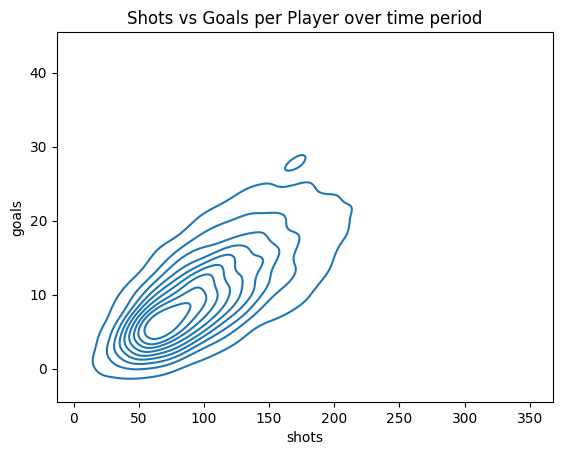

In [4]:
sns.kdeplot(x='shots', y='goals', data=data)
plt.title('Shots vs Goals per Player over time period')

<h2> Question 2. </h2>
<p> What do you think the variable Corsi is trying to measure? Why might it be useful compared to just goals scored at both the team and the player level? </p> </br>

<strong> Answer: </strong> The variable corsi is defined as: the net difference in shots taken by your team and the other team. It's useful to use vs just goals scored, because we can understand who has more possesion of the ball, and also who might take shots but still keeps the ball afterwards or wins the puck back afterwards.

<h2> Question 3. </h2>
<p> Why would we possibly care about your relative corsi percentage versus others on your team versus just your relative shot number compared to the league? How is this similar to the idea of a team fixed effect? </p>

<strong> Answer: </strong> It makes sense to use the relative corsi percentage versus other than to simply use the relative shot number, because it gives insights into how you many shots you allowed to other team to gain/get. It sort of works as a team fixed effect, because we can assume that players will continously show the same characteristics over multiple games, and so we can hold their corsi percentage fixed.

<h2> Question 4. </h2>
<p> In basketball, shooting percentage is thought to be very replicable over time (we will revisit this
later in the course). For example, Stephen Curry seems to always have a 3-point shooting
percentage among the top 10 players in the NBA.  Is it the case that hockey relative shooting
percentage (PDO) is highly replicable, i.e. that it is serially correlated? Pooling observations over
the full sample period, the 95th percentile in PDO was 103.38. Assuming someone had a PDO at
this level in year t, what would you forecast their PDO to be in year t+1 using just their previous year’s
performance? What percentile, over the full sample period, does this correspond to? </p>

In [5]:
data.loc[data['name'] == 'Adam.Burish']

,var1,name,position,team,games,season,season_start,age,salary,goals,assists,goals_sixty,assists_sixty,toi,shots,corsifor,corsiagainst,corsi,pdo,cfrel_percent,age_sq,lagged_pdo,lagged_goals,lagged_cfrel_percent,lagged_shots,lagged_assists,lagged_toi
1,882,Adam.Burish,C,CHI,81,20000000.0,2007,24,NaN,3,4,0.26,0.35,680.21,60,425,547,-122,96.62,-7.24,576,NaN,NaN,NaN,NaN,NaN,NaN
2,883,Adam.Burish,C,CHI,83,20000000.0,2008,25,0.713,9,5,0.87,0.48,622.11,91,499,436,63,100.73,-1.11,625,96.62,3.0,-7.24,60.0,4.0,680.21
3,885,Adam.Burish,C,DAL,63,20000000.0,2010,27,1.000,7,6,0.56,0.48,755.82,75,584,721,-137,100.79,-2.93,729,100.73,9.0,-1.11,91.0,5.0,622.11
4,886,Adam.Burish,C,DAL,65,20000000.0,2011,28,1.300,6,11,0.52,0.96,689.02,69,613,623,-10,100.77,0.61,784,100.79,7.0,-2.93,75.0,6.0,755.82


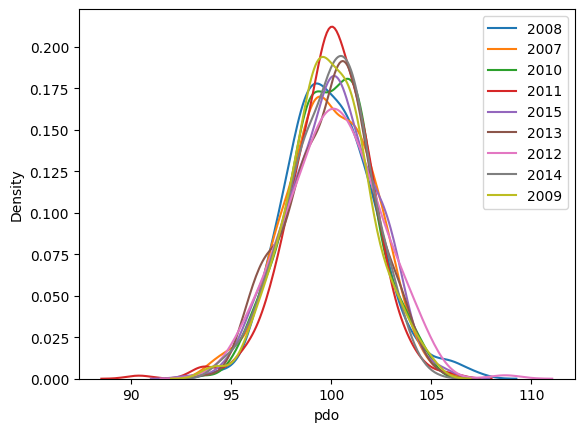

In [6]:
# player = data.groupby('name')
# player['roll_avg'] = player['pdo'].rolling(2).mean()
# data['roll_avg'] = data.groupby('name')['pdo'].rolling(2).mean()
# result = data.groupby('name')['pdo'].rolling(2).mean()
# result['Adam.Burish']

# season = data.groupby('season_start')
seasons = data['season_start'].unique()
fig, ax = plt.subplots(1,1)
for i in seasons:
    season_data = data.loc[data['season_start'] == i]
    sns.kdeplot(x='pdo', data=season_data, label=f'{i}')
plt.legend()

In [7]:
data_dropped = data.dropna()
Y = data_dropped[['pdo']]
X = data_dropped[['lagged_pdo']]

linear = LinearRegression(fit_intercept=True).fit(X, Y)
value = linear.predict([[103.38]])[0][0]

print(value)
percentile = stats.percentileofscore(np.array(X), value)
print(Y.quantile(.57))
# linear = sm.ols("lagged_pdo ~ pdo", data=data).fit(cov_type='HC2')
# print(linear.predict(103))

100.48635920550696
pdo    100.41
Name: 0.57, dtype: float64


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<strong> Answer: </strong>We find that the predicted value would be 100.48 POD and the 57th percentile.

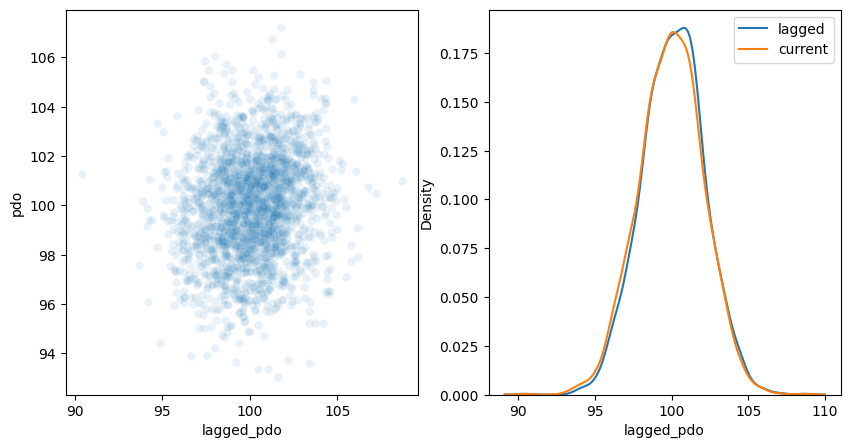

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(x='lagged_pdo', y='pdo', data=data, alpha=0.1, ax=ax[0])
sns.kdeplot(x='lagged_pdo', data=data, label='lagged', ax=ax[1])
sns.kdeplot(x='pdo', data=data, label='current', ax=ax[1])
plt.legend()

<h2> Question 6. </h2>
<p> Try to predict goals in season t, using only information from season t-1, employing at least two
different specifications. What is your preferred specification? For which player-season did you forecast the most goals for each specification? </p>

In [17]:
data_dropped

,var1,name,position,team,games,season,season_start,age,salary,goals,assists,goals_sixty,assists_sixty,toi,shots,corsifor,corsiagainst,corsi,pdo,cfrel_percent,age_sq,lagged_pdo,lagged_goals,lagged_cfrel_percent,lagged_shots,lagged_assists,lagged_toi
2,883,Adam.Burish,C,CHI,83,20000000.0,2008,25,0.713,9,5,0.87,0.48,622.11,91,499,436,63,100.73,-1.11,625,96.62,3.0,-7.24,60.0,4.0,680.21
3,885,Adam.Burish,C,DAL,63,20000000.0,2010,27,1.000,7,6,0.56,0.48,755.82,75,584,721,-137,100.79,-2.93,729,100.73,9.0,-1.11,91.0,5.0,622.11
4,886,Adam.Burish,C,DAL,65,20000000.0,2011,28,1.300,6,11,0.52,0.96,689.02,69,613,623,-10,100.77,0.61,784,100.79,7.0,-2.93,75.0,6.0,755.82
7,2695,Adam.Hall,RC,T.B,100,20000000.0,2010,30,0.600,8,11,0.43,0.60,1106.14,164,865,1000,-135,96.24,-5.29,900,97.59,4.0,-0.12,75.0,4.0,615.62
8,2696,Adam.Hall,RC,T.B,57,20000000.0,2011,31,0.600,2,5,0.24,0.60,503.80,55,355,440,-85,96.27,-4.17,961,96.24,8.0,-5.29,164.0,11.0,1106.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,6570,Zack.Smith,CL,OTT,73,20000000.0,2015,27,2.000,13,7,0.91,0.49,854.55,72,834,799,35,101.61,4.41,729,97.82,12.0,-2.98,125.0,5.0,1078.36
3000,6834,Zack.Stortini,R,EDM,77,20000000.0,2009,24,0.700,3,9,0.26,0.79,684.75,41,513,713,-200,103.56,-3.48,576,102.81,3.0,-2.26,34.0,9.0,524.85
3002,2383,Zemgus.Girgensons,CL,BUF,61,20000000.0,2014,20,0.925,11,10,0.77,0.70,859.51,80,551,997,-446,99.44,-2.00,400,98.90,7.0,2.04,91.0,12.0,879.02
3003,2384,Zemgus.Girgensons,CL,BUF,63,20000000.0,2015,21,0.833,3,8,0.23,0.61,780.62,79,636,673,-37,100.00,1.29,441,99.44,11.0,-2.00,80.0,10.0,859.51


0.6131357061391112
[(0.5659844598292345, 'games'), (0.0973378170530764, 'age'), (0.05886899913435012, 'goals'), (0.0, 'assists'), (0.007392558195106434, 'goals_sixty')]


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- assists
- cfrel_percent
- pdo
- shots
- toi
Feature names seen at fit time, yet now missing:
- lagged_assists
- lagged_cfrel_percent
- lagged_pdo
- lagged_shots
- lagged_toi

  warnings.warn(message, FutureWarning)


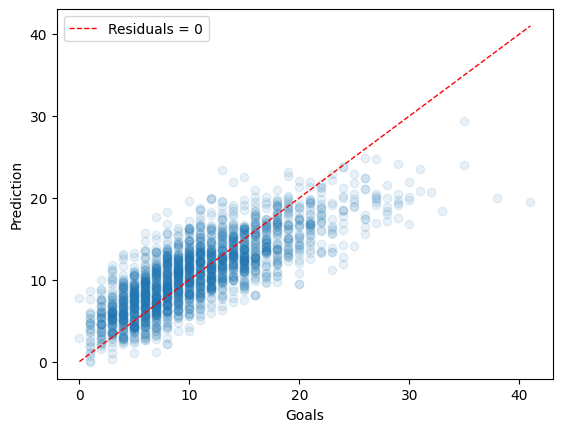

In [381]:
# We could just run a simple linear regression again, but let's actually run a lasso regression to understand what parameters explain most variation.
# We built a lasso regression using the lagged data as our train data, and predicting on the new season.
Y_train = data_dropped['lagged_goals']
X_train = data_dropped[['lagged_pdo', 'lagged_cfrel_percent', 'lagged_shots', 'lagged_assists', 'lagged_toi']]

Y_test = data_dropped['goals']
X_test = data_dropped[['pdo', 'cfrel_percent', 'shots', 'assists', 'toi']]
lasso = LassoCV(cv=5).fit(X_train, Y_train)
print(lasso.score(X_train,Y_train))

y_pred = lasso.predict(X_test)
resid = Y_test - y_pred

print(list(zip(lasso.coef_, X)))
# frame = pd.DataFrame(y_pred, y_test)
# sns.residplot(data=frame, x=)
plt.scatter(Y_test, y_pred, alpha=0.1)
plt.xlabel('Goals')
plt.ylabel('Prediction')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=1, label='Residuals = 0')
plt.legend();

In [382]:
highest_pred = y_pred.max()
# print(highest_pred)
# print(np.where(y_pred == highest_pred)[0][0])
# X_test.iloc[49]
data_dropped.iloc[49]

var1                             5196
name                    Alex.Ovechkin
position                           LR
team                              WSH
games                              93
season                     20000000.0
season_start                     2008
age                                22
salary                            9.0
goals                              35
assists                            28
goals_sixty                      1.43
assists_sixty                    1.14
toi                           1472.77
shots                             336
corsifor                         1753
corsiagainst                     1315
corsi                             438
pdo                            100.77
cfrel_percent                    4.47
age_sq                            484
lagged_pdo                     101.87
lagged_goals                     37.0
lagged_cfrel_percent              4.1
lagged_shots                    275.0
lagged_assists                   27.0
lagged_toi  

In [383]:
data_dropped.loc[data_dropped['salary'] == 8.5]
# data_dropped['salary'].value_counts()

,var1,name,position,team,games,season,season_start,age,salary,goals,assists,goals_sixty,assists_sixty,toi,shots,corsifor,corsiagainst,corsi,pdo,cfrel_percent,age_sq,lagged_pdo,lagged_goals,lagged_cfrel_percent,lagged_shots,lagged_assists,lagged_toi
929,6643,Eric.Staal,CL,CAR,48,2.000e+07,2012,27,8.5,13,27,1.06,2.2,734.77,86,774,775,-1,103.09,-2.37,729,98.28,12.0,2.65,154.0,27.0,1249.53


I don't fully understand what is meant by specification, but using the lagged data I predict the highest goals to be 29.32 goals for Alex Ovechkin, who according to a quick google search is widely regarded as one of the greatest goal scorers.

<hr style="height:1.2pt">
<h2> Part 2 Question 7a) </h2>
<p> Estimate Pythagorean wins using 2 different coefficients over the 2019 season. Which one fits the actual wins over the 2019 season best? </p>

<p> The pythagorean theorem formula as applied in baseball was -> $Pythagorean = \frac{RS^c}{RS^c + RA^c}$ where $RS$ are average number of runs scored per game and $RA$ are the average number of runs allowed. We can estimate the same formula for goals for and goals against. </p> 

In [385]:
standings.head()
standings['Year'].unique()

array([2018. , 2019. , 2018.5])

In [386]:
# we compute the average Goals for and goals against
standings['GF_avg'] = np.array(standings['GF'] / standings['GP'])
standings['GA_avg'] = np.array(standings['GA'] / standings['GP'])

def pythagorean(k, year):
    standings['Pred_pyt'] = standings['GP'] *(standings['GF_avg']**k / (standings['GF_avg']**k + standings['GA_avg']**k))
    standings['dif'] = standings['W'] - standings['Pred_pyt']
    MSE_score = ((standings.loc[standings['Year'] == year]['dif']**2).sum())/len(standings.loc[standings['Year'] == year]['dif'])
    return MSE_score
standings.head()

,Team,GP,W,L,OL,PTS,PTS%,GF,GA,Year,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,GF_avg,GA_avg,Pred_pyt,dif
0,Tampa Bay Lightning*,82,62,16,4,128,0.780,325,222,2018.0,NaN,NaN,NaN,NaN,NaN,3.963,2.707,80.158,-18.158
1,Boston Bruins*,82,49,24,9,107,0.652,259,215,2018.0,NaN,NaN,NaN,NaN,NaN,3.159,2.622,70.794,-21.794
2,Toronto Maple Leafs*,82,46,28,8,100,0.610,286,251,2018.0,NaN,NaN,NaN,NaN,NaN,3.488,3.061,64.332,-18.332
3,Montreal Canadiens,82,44,30,8,96,0.585,249,236,2018.0,NaN,NaN,NaN,NaN,NaN,3.037,2.878,51.634,-7.634
4,Florida Panthers,82,36,32,14,86,0.524,267,280,2018.0,NaN,NaN,NaN,NaN,NaN,3.256,3.415,31.526,4.474


22


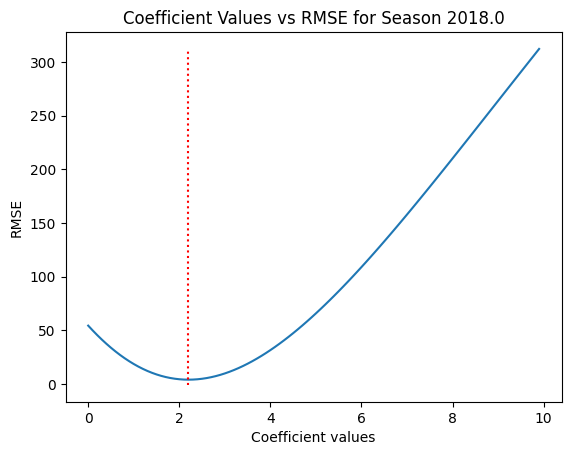

In [387]:
# Let's optimize to find the optimal coefficient which reduces the MSE
def plot(year):
    scores = []
    ks = np.arange(0, 10, 0.1)
    for i in ks:
        scores.append(pythagorean(i, year))
    x_label = "RMSE" 
    min_score_index = scores.index(min(scores))
    plt.plot(ks, scores)
    plt.title(f'Coefficient Values vs RMSE for Season {year}')
    plt.vlines(ks[min_score_index], ymin= -1, ymax=max(scores), color='red', linestyles='dotted')
    plt.xlabel('Coefficient values')
    plt.ylabel(x_label)
    print(scores.index(min(scores)))
    
plot(2018.00)

<h2> Part 2 Question 7b) </h2>
<p> Now apply these two coefficients to the first half of the 2018 season. Which one minimizes the Root Mean Squared Error of predicted points per game in the second half. Is Pythagorean wins an improvement over points per game in the first half?</p>

<p> In 7a) i added a function to iterate over a range of coefficient values that minimzies the MSE. The best coefficient I found was 2.2. I now do the same thing for the first half of the 2018 season, and the RMSE.

In [388]:
# we compute the average Goals for and goals against
standings['GF_avg'] = np.array(standings['GF'] / standings['GP'])
standings['GA_avg'] = np.array(standings['GA'] / standings['GP'])

def pythagorean(k, year):
    standings['Pred_pyt'] = standings['GP'] *(standings['GF_avg']**k / (standings['GF_avg']**k + standings['GA_avg']**k))
    standings['dif'] = standings['W'] - standings['Pred_pyt']
    RMSE_score = np.sqrt(((standings.loc[standings['Year'] == year]['dif']**2).sum())/len(standings.loc[standings['Year'] == year]['dif']))
    return RMSE_score

standings.head()

# test_data = standings.loc[standings['Year'] == 2018.00]
pythagorean(2.2, 2018.50)
# standings.head()

1.2613579731874152

23


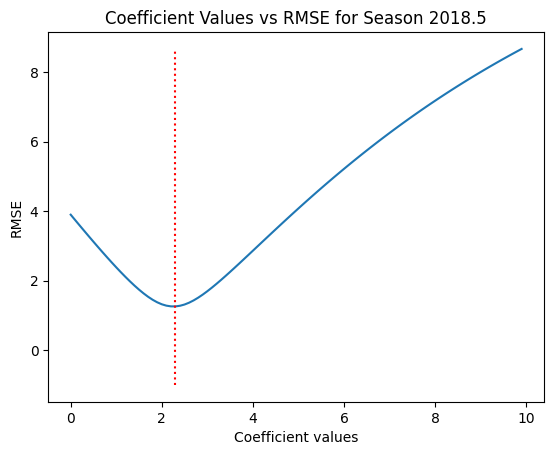

In [389]:
plot(2018.50)

<strong> Answer: </strong>I find the best coefficient value to be 2.3 which minimizes the RMSE the best in the first half of 2018.

<h2> Bonus Question </h2>
<p> Why do shootouts make hockey a less than ideal venue for Pythagorean wins? </p>


A shootout is simply a single player vs the goal keeper, hence we cannot evaluate how other players are stopping the opponent from scoring, which is a key element of the pythagorean win formula. We estimate how many scores per game you gained and how many you allowed. In the shootout it is simply a player vs a goalie.

<h2> Part 3. Putting it all together </h2>
<p> Given what you found in part 1 and what we discussed in the Moneyball readings, what kinds of players do you think might have been undervalued in the hockey market over this period? Create a back of the envelope estimate of how much value the most underpaid player could add to a team that scores exactly as many goals as its opponents using your coefficients from 7. (There is no perfect answer, creativity is good. And hopefully you can have some fun with it. If you assume that people get paid based on their output in the current season or past season that is fine if the coding is too much.) </p>

<strong> Answer: </strong> In order ot answer this question we need define what undervalued is and how we specify that. Furthermore, we shall look into what explains the variation in salary the most. What variables explain most of the variance in the salary, this will give us an insight into why some players might be overvalued.

<AxesSubplot:>

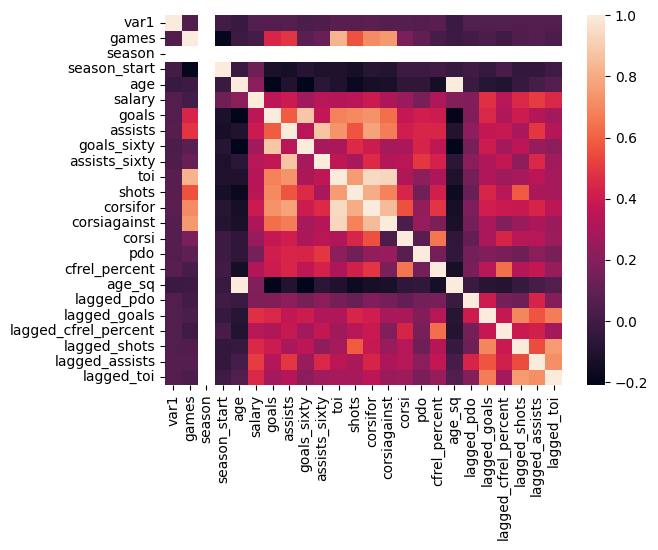

In [390]:
# Here a correlation heatmap
sns.heatmap(data_dropped.corr())

In [391]:
# We shall use a PCA (Principal Component Analysis) to reduce the dimensionality of our dataset.
# Important to remember that we cant use categorical variables in a PCA.
# Let's also use the standardscaler to scale the variables of interest

# Separate predictors and response
X, y = data_dropped.drop(columns=['salary']), data_dropped['salary']
# We further drop categorical values since they can't be used in a PCA analysis. We shall add things such as position in later.
X = X.drop(columns=['var1', 'name', 'position', 'team', 'season', 'season_start'])
# We create a train and test set in order to build a model that also generalizes well.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X.copy()
y_train = y.copy()

# Let's compute the correlations
corr = X_train.corr().unstack().to_dict()

correlations = {}
high_corr = {}
keys = []

for key in corr:
    if key[0] != key[1]:
        if corr[key] > 0.5 or corr[key] < -0.5:
            correlations.update({key : corr[key]})

for key in correlations:
    keys.append(key)

keys = list(set(map(tuple, map(sorted, keys))))
for i in keys:
    high_corr.update({i : correlations[i]})

print("The following pairs of predictor variables have correlation greater than 0.5 or less than -0.5:")
display(high_corr)


The following pairs of predictor variables have correlation greater than 0.5 or less than -0.5:


{('lagged_assists', 'lagged_goals'): 0.5695357138958379,
 ('lagged_goals', 'lagged_toi'): 0.6694778632851692,
 ('corsifor', 'toi'): 0.9407417737311236,
 ('games', 'toi'): 0.821609890457352,
 ('assists', 'toi'): 0.7341984858676375,
 ('lagged_goals', 'lagged_shots'): 0.6962496775009318,
 ('goals', 'goals_sixty'): 0.8810532087965165,
 ('age', 'age_sq'): 0.995327571795921,
 ('cfrel_percent', 'lagged_cfrel_percent'): 0.6326649952972667,
 ('assists', 'corsifor'): 0.7762015078718226,
 ('corsi', 'corsifor'): 0.5564720813609134,
 ('lagged_shots', 'lagged_toi'): 0.7531896837739479,
 ('assists', 'shots'): 0.5675319901184135,
 ('corsifor', 'goals'): 0.7259650130344224,
 ('assists', 'goals'): 0.5863837166874559,
 ('corsiagainst', 'toi'): 0.9319340890920743,
 ('corsifor', 'shots'): 0.8025118076061297,
 ('games', 'shots'): 0.5638693237336756,
 ('shots', 'toi'): 0.7546542063633903,
 ('corsiagainst', 'corsifor'): 0.8493216292670323,
 ('lagged_shots', 'shots'): 0.5801362932716516,
 ('goals', 'toi'): 0.6

In [392]:
# next we fit a linear regression model on our unscaled training data using all predictors
y_train_pred = LinearRegression().fit(X_train, y_train).predict(X_train)
# y_test_pred = LinearRegression().fit(X_train, y_train).predict(X_test)

linreg_train_r2 = r2_score(y_train, y_train_pred)
# linreg_test_r2 = r2_score(y_test, y_test_pred)

print(f"linear regression train R^2: {linreg_train_r2:.4f}")
# print(f"linear regression test R^2: {linreg_test_r2:.4f}")

linear regression train R^2: 0.5337


In [393]:
print(len(X_train.columns))

20


<h3> Next we standardize both X_train and perform a PCA with a different number of components

In [394]:
X_train_scaled = StandardScaler().fit(X).transform(X_train)

ks = [1,2,3,4,5,6,8,10,12,15, 20]
val_mses_mean = []

for k in ks:
    X_train_transformed = PCA(n_components=k).fit_transform(X_train_scaled)
    lreg = LinearRegression()
    lreg.fit(X_train_transformed, y_train).predict(X_train_transformed)
    mse_score = cross_validate(lreg, X_train_transformed, y_train, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
    val_mses_mean.append(-1*np.mean(mse_score['test_score']))
    
best_k = ks[np.argmin(val_mses_mean)]
print(f"The best k is {best_k}.")

The best k is 20.


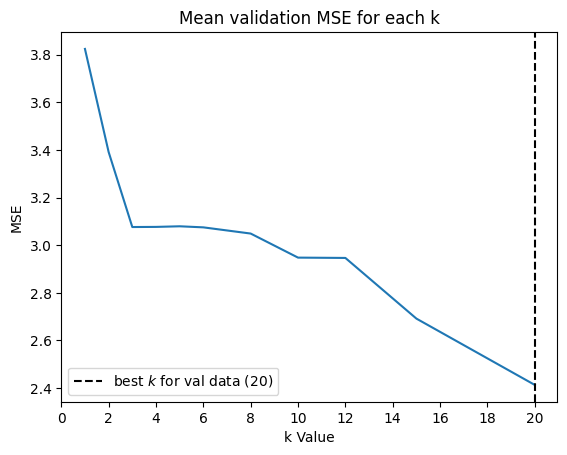

In [395]:
plt.plot(ks, val_mses_mean)
plt.title("Mean validation MSE for each k")
plt.xlabel("k Value")
plt.ylabel("MSE")
plt.axvline(best_k, c="k", ls='--', label=rf'best $k$ for val data ({best_k})')
plt.legend()
plt.xticks(range(0,21,2));

<h3> Using 20 components we fit our Linear Regression. </h3>
We shall receive the same as the unscaled regression, since we are using all predictors. Interesting to see that all predictors are considered by the PCA.

In [396]:
pca = PCA(n_components=20).fit(X_train_scaled)
X_train_transform = pca.transform(X_train_scaled)
# X_test_transform = pca.transform(X_test_scaled)

lreg = LinearRegression().fit(X_train_transform, y_train)
y_train_pred = lreg.predict(X_train_transform)
# y_test_pred = lreg.predict(X_test_transform)

pcr_train_r2 = r2_score(y_train, y_train_pred)
# pcr_test_r2 = r2_score(y_test, y_test_pred)

print(f"PCR train R^2: {pcr_train_r2:.4f}")
# print(f"PCR test R^2: {pcr_test_r2:.4f}")

PCR train R^2: 0.5337


In [397]:
print(len(y_train_pred))

2223


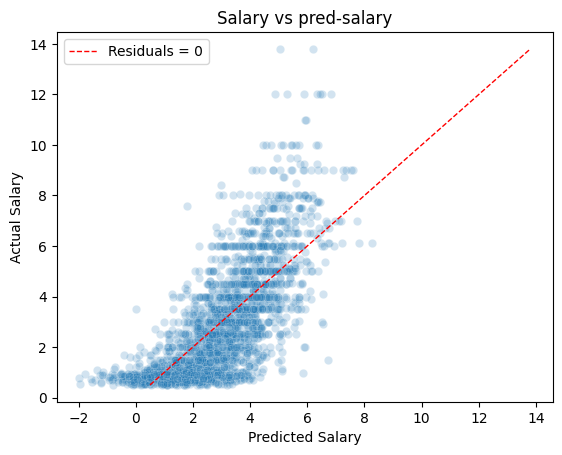

In [398]:
resid = y_train - y_train_pred 
sns.scatterplot(x=y_train_pred, y=y_train, alpha=0.2)
plt.ylabel('Actual Salary')
plt.xlabel('Predicted Salary')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=1, label='Residuals = 0')
plt.title('Salary vs pred-salary')
plt.legend();

In [399]:
frame_data = [resid, y_train, y_train_pred]
df = pd.DataFrame({'dif': resid, 'actual_salary':y_train, 'pred_salary':y_train_pred})
df = df.sort_values(by='dif')
df = df.reset_index()
df

,index,dif,actual_salary,pred_salary
0,2141,-5.241,1.500,6.741
1,962,-4.869,0.984,5.853
2,1944,-4.078,1.050,5.128
3,2902,-3.965,1.150,5.115
4,41,-3.924,2.000,5.924
...,...,...,...,...
2218,2988,6.099,12.000,5.901
2219,292,6.721,12.000,5.279
2220,2989,7.115,12.000,4.885
2221,2179,7.613,13.800,6.187


<h3> Now let's find the most undervalued players. </h3>

In [400]:
# Let's recover the names of the players
data.iloc[list(df['index'])]

,var1,name,position,team,games,season,season_start,age,salary,goals,assists,goals_sixty,assists_sixty,toi,shots,corsifor,corsiagainst,corsi,pdo,cfrel_percent,age_sq,lagged_pdo,lagged_goals,lagged_cfrel_percent,lagged_shots,lagged_assists,lagged_toi
2141,1709,Pascal.Dupuis,LR,PIT,63,2.000e+07,2012,33,1.500,19,20,1.26,1.33,902.02,137,937,864,73,104.93,4.68,1089,100.28,23.0,-1.40,165.0,34.0,1192.05
962,4251,Evgeni.Malkin,CR,PIT,106,2.000e+07,2008,22,0.984,20,55,0.78,2.14,1544.02,187,1356,1518,-162,103.60,-1.49,484,103.23,29.0,3.37,174.0,39.0,1495.72
1944,5852,Mike.Ribeiro,C,NSH,88,2.000e+07,2014,34,1.050,15,32,0.68,1.44,1329.92,73,1503,1148,355,100.82,6.59,1156,100.08,11.0,3.26,62.0,17.0,1096.97
2902,5645,Vaclav.Prospal,LC,NYR,75,2.000e+07,2009,34,1.150,12,25,0.64,1.34,1119.77,112,1068,986,82,102.94,3.13,1156,98.23,11.0,3.41,116.0,17.0,1088.57
41,906,Alex.Burrows,RL,VAN,97,2.000e+07,2010,29,2.000,29,25,1.29,1.11,1346.55,147,1384,1125,259,101.50,3.58,841,103.30,23.0,3.83,167.0,24.0,1257.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,5304,Zach.Parise,L,MIN,53,2.000e+07,2012,28,12.000,11,10,0.83,0.76,791.25,130,741,627,114,96.32,7.66,784,98.34,22.0,1.66,220.0,26.0,1592.68
292,5859,Brad.Richards,C,NYR,56,2.000e+07,2012,32,12.000,9,16,0.70,1.24,773.44,77,801,756,45,100.59,1.77,1024,99.59,18.0,0.57,171.0,24.0,1562.11
2989,5305,Zach.Parise,L,MIN,80,2.000e+07,2013,29,12.000,13,25,0.67,1.29,1161.91,172,1167,932,235,100.04,7.97,841,96.32,11.0,7.66,130.0,10.0,791.25
2179,3425,Patrick.Kane,R,CHI,73,2.000e+07,2015,26,13.800,21,30,1.08,1.55,1164.69,150,1131,1018,113,102.12,2.57,676,101.91,27.0,-1.38,147.0,21.0,1291.88


The most undervalued player is Pascal Dupuis his predicted value is 6.741 million dollars but he earned 1.5 miollion dollars. The most overvalued player was Jonathan Toews who earned 13.8 million dollars, but should have gotten 5.06 mio

### We can run a pca transformation to display some of the variation in the salary data

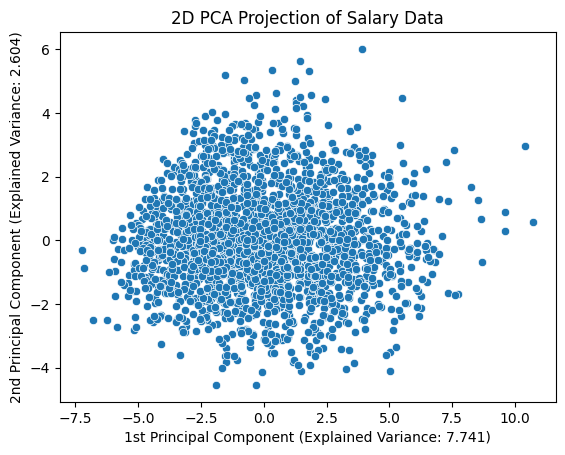

In [402]:
X_scaled = StandardScaler().fit(X).transform(X)

pca = PCA(n_components=20).fit(X_scaled)
X_transformed = pca.transform(X_scaled)

ax = sns.scatterplot(data=X_transformed, x=X_transformed[:,0], y=X_transformed[:,1])   
ax.set_xlabel(f"1st Principal Component (Explained Variance: {pca.explained_variance_[0]:.3f})")
ax.set_ylabel(f"2nd Principal Component (Explained Variance: {pca.explained_variance_[1]:.3f})")
ax.set_title("2D PCA Projection of Salary Data");